In [1]:
# I like to start by checking if the GPU was initiated succesfully,
# and by seeing the tensroflow and python versions being used
# by the notebook.

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf, sys
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('tensorflow version: %s' % tf.__version__)
print('python version: %s' % sys.version)
print('python executable location: %s' % sys.executable)

# --------------------------------------------------------------
# --------------------------------------------------------------

%matplotlib inline
%load_ext autoreload
%autoreload 2

from helpers import *
import os, sys, tarfile, time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator
import pickle

params = {'legend.fontsize': 'x-large',
          'font.size'      : 11,
          'figure.figsize' : (17, 6),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4743611279148366645
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11324823962
locality {
  bus_id: 1
}
incarnation: 12430722569176896966
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]
tensorflow version: 1.0.0
python version: 3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
python executable location: /home/aind2/anaconda3/envs/aind-dog/bin/python


Reading train_*.npy , cv_*.npy , test_*.npy and and u_mean.pkl files....
n_movies 27278
Runtime: 0 min 6 sec


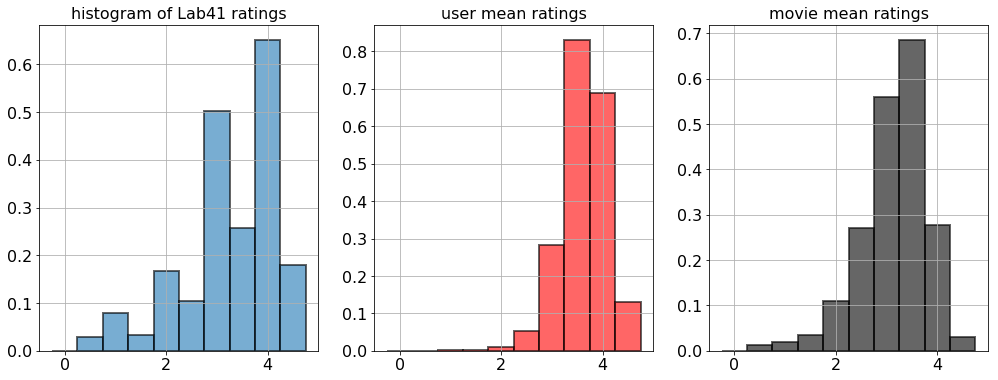

In [2]:
# Read Lab41 dataset into:
#                          train_Y, cv_Y, test_Y
#                          train_Y_indices, cv_Y_indices, test_Y_indices
start = time.time()
#...................................................
train_Y_indices, train_Y, cv_Y_indices, \
        cv_Y, test_Y_indices, test_Y, \
        n_users, n_movies, u_mean_dict, v_mean_dict = read_and_split_data()

ax = plt.subplot(131)
ax.hist(np.concatenate((train_Y, cv_Y, test_Y)), bins=np.arange(-.25, 5.25, 0.5), alpha=.6, \
         edgecolor='black', linewidth=2, normed=True);
ax.set_title('histogram of Lab41 ratings');

#...................................................

ax = plt.subplot(132)
ax.hist((list(u_mean_dict.values())), bins=np.arange(-.25, 5.25, 0.5), alpha=.6, \
        color='red', edgecolor='black', linewidth=2, normed=True);
ax.set_title('user mean ratings');

ax = plt.subplot(133)

ax.hist((list(v_mean_dict.values())), bins=np.arange(-.25, 5.25, 0.5), alpha=.6, \
        color='black', edgecolor='black', linewidth=2, normed=True);
ax.set_title('movie mean ratings');

print_runtime(start)

In [3]:
start = time.time()

train_u_mean, train_v_mean = get_train_u_mean(train_Y_indices, u_mean_dict, v_mean_dict)

print_runtime(start)

Runtime: 0 min 16 sec



NUM_EPOCHS: 10
LAMBDA: 0.0
k: 10
lr: 0.01
n_batches: 781
BATCH_SIZE: 16384
New epoch: 1 ******************************
batch_no: 781, _loss estimate: 1.3867, t= 75.65 sec
mae_train: 0.6364, **mae_cv: 0.6513**, mae_test: 0.6515,  mean(preds): 3.5174
New epoch: 2 ******************************
batch_no: 781, _loss estimate: 0.8240, t= 63.76 sec
mae_train: 0.5978, **mae_cv: 0.6274**, mae_test: 0.6278,  mean(preds): 3.5399
New epoch: 3 ******************************
batch_no: 781, _loss estimate: 0.7917, t= 64.07 sec
mae_train: 0.5792, **mae_cv: 0.6211**, mae_test: 0.6214,  mean(preds): 3.5297
New epoch: 4 ******************************
batch_no: 781, _loss estimate: 0.7720, t= 64.13 sec
mae_train: 0.5676, **mae_cv: 0.6178**, mae_test: 0.6181,  mean(preds): 3.5312
New epoch: 5 ******************************
batch_no: 781, _loss estimate: 0.7596, t= 63.80 sec
mae_train: 0.5608, **mae_cv: 0.6166**, mae_test: 0.6169,  mean(preds): 3.5289
New epoch: 6 ******************************
batch_no: 

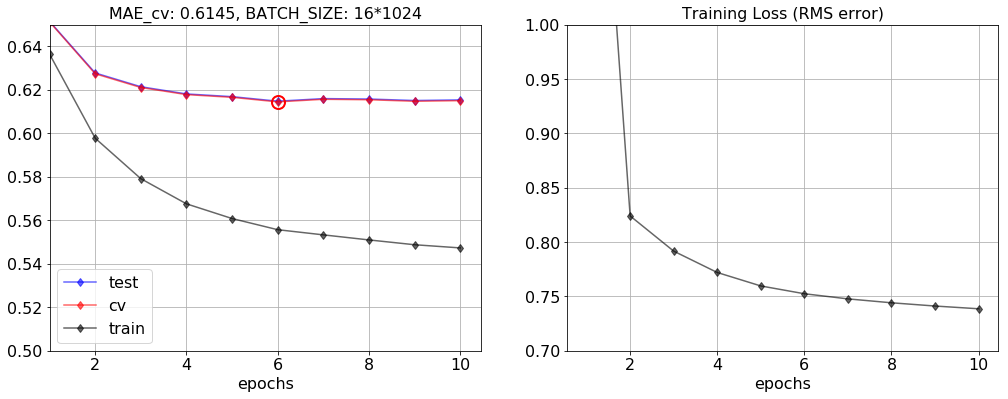

In [22]:
start = time.time()
# hyperparameters
# BATCH_SIZE = 1024*16
BATCH_SIZE_arr = [1024*16]
# LAMBDA_ARR = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.00125]
LAMBDA = 0.00
k = 10 # an important hyperparameter.
lr = 0.01
NUM_EPOCHS = 10
if 'out.txt' in os.listdir(): 
    os.remove('out.txt')
    
for BATCH_SIZE in BATCH_SIZE_arr:
    #.............................................. 
    train, loss, reg, Y_indices, Y, U, V, Y_pred, UV_xft, UU_xft, VV_xft, u_mean, v_mean = \
                            construct_graph(LAMBDA, k, lr, BATCH_SIZE, n_users, n_movies)
    #.............................................. 

    mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, mean_preds, n_batches, preds, \
                   _U, _V, _UV_xft, _UU_xft, _VV_xft = \
                         train_the_model(Y_indices, Y, train_Y_indices, train_Y, BATCH_SIZE, 
                   NUM_EPOCHS, LAMBDA, k, lr, 
                   train, loss, reg, U, V, Y_pred,
                   cv_Y, cv_Y_indices, test_Y, test_Y_indices,
                   UV_xft, UU_xft, VV_xft, 
                   train_u_mean, train_v_mean, u_mean, v_mean)
    #.............................................. 
    # plotting....
    ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, BATCH_SIZE)

#.............................................. 
print_runtime(start)

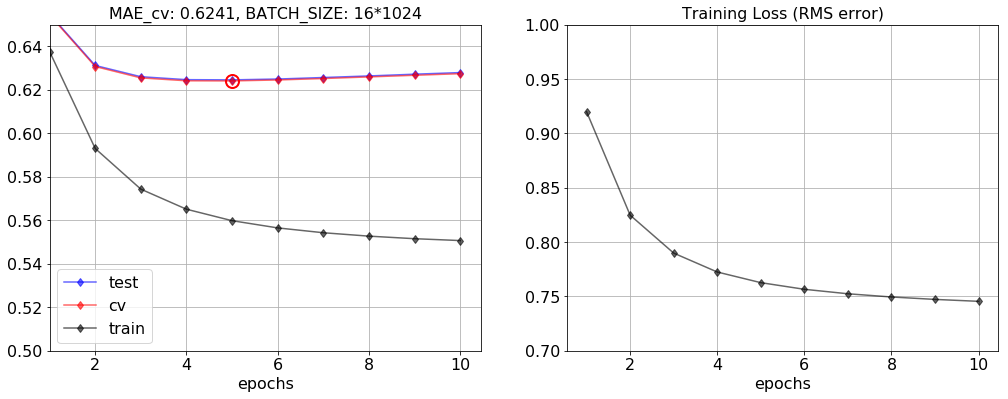

In [21]:
ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, BATCH_SIZE)